In [3]:
# Import the required packages/ libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam                 

In [ ]:
IMAGE_SIZE = (224, 224) # size of the images that the model will use
BATCH_SIZE = 32
NUM_CLASSES = 4
dataset_dir = 'dataset_rotated'


In [5]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 2999 images belonging to 4 classes.
Found 1283 images belonging to 4 classes.


In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Adding custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)   #1024
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [7]:
# Combine the base model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Freeze the base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Learning Rate Scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [11]:
checkpoint_path = "training_checkpoints/best_model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss')
tensorboard_callback = TensorBoard(log_dir="logs")

callbacks = [early_stopping, checkpoint, tensorboard_callback]


In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)
#    output6 model    


Epoch 1/50


C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3913 - loss: 4.1215

C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.3925 - loss: 4.1170 - val_accuracy: 0.7178 - val_loss: 3.1097
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.7395 - loss: 2.9718 - val_accuracy: 0.8059 - val_loss: 2.8122
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8481 - loss: 2.6608 - val_accuracy: 0.8246 - val_loss: 2.7312
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.8933 - loss: 2.4667 - val_accuracy: 0.8480 - val_loss: 2.6108
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9070 - loss: 2.3643 - val_accuracy: 0.8394 - val_loss: 2.5969
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9385 - loss: 2.2229 - val_accuracy: 0.8457 - val_loss: 2.5247
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9387 - loss: 2.1491 - val_accuracy: 0.8550 - val_loss: 2.4351
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9443 - loss: 2.0638 - val_accuracy: 0.8527 - val_loss: 2.

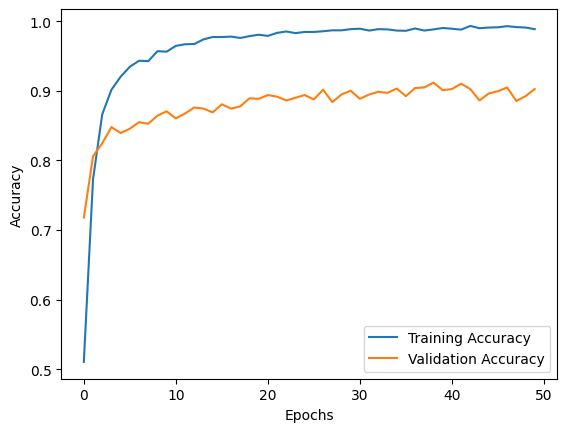

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()  

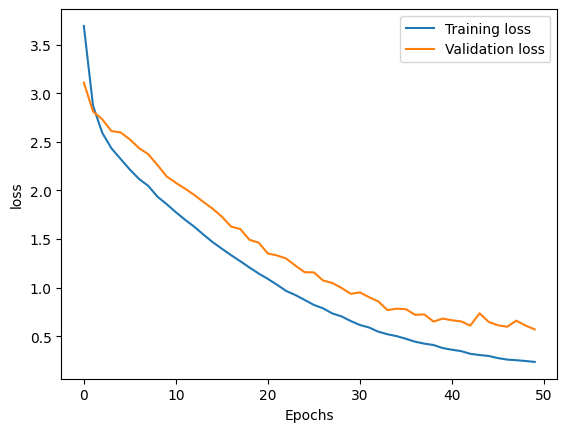

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [ ]:
# Saving the model
model.save('final_detection_model\output6_model_keras.keras')
